### User Story: A researcher who is retrieving citations of a COVID-19 paper on DataCite and found that this paper is cited by a ORKG comparison and he wants to calculate the average R0 of all COVID-19 Asian studies to perform further analysis.

In [4]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [5]:
# Prepare the GraphQL client

_transport = RequestsHTTPTransport(
    url='https://www.orkg.org/orkg/graphql-federated',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

In [10]:

query = gql("""{
  #DataCite query
  work(id: "https://doi.org/10.1101/2020.03.08.20030643") {
    id
    titles { title }
    citations {
      totalCount
      nodes {
        titles { title }
        publisher
            #ORKG query
        comparison {
          label
          doi { label }
              # Retrieving countries of Asian (AS) continent and filtering them 
          relatedPapers(property: "location", value: "AS") {
            id { label }
            authors { label }
                #DataCite query
            work { publisher }
                #ORKG query
            contributions {
              contribution_details {
                property { label }
                label
                contribution_details {
                    property { label }
                    label
                  contribution_details {
                    property { label }
                    label
                  }
    } } } } } } } } }
""")

import json
data = client.execute(query)
relatedPapers=data['work']['citations']['nodes'][0]['comparison'][0]['relatedPapers']

## Metadata analysis: calculating the frequency of publishing COVID-19 Asian studies of each publisher
Note: Change in the results can be observed due to the difference of data. The results presented over here retrived by executing the query on live ORKG data whereas results shown in the paper are generated on localhost.

21


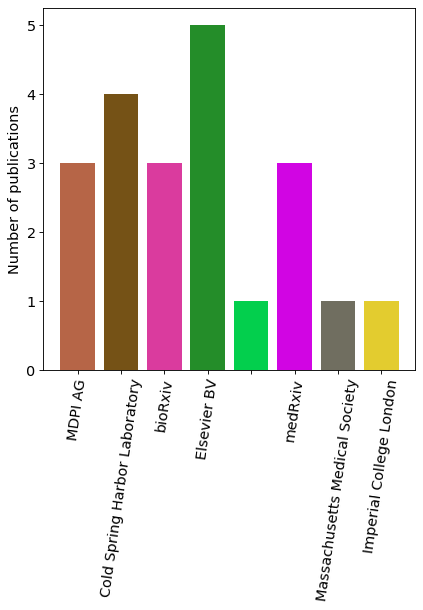

In [11]:
from statistics import mean
print(len(relatedPapers))
papers=[]
for i in relatedPapers:
    papers.append(i['work']['publisher'])

figure(figsize=(6, 6), dpi=80)
# create a dataset
height = Counter(papers).values()
bars = Counter(papers).keys()
x_pos = np.arange(len(bars))

number_of_colors =  len(Counter(papers).keys())

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

plt.bar(x_pos, height, color=color)
plt.ylabel('Number of publications')
plt.yticks(np.arange(0, max(height)+1, 1))

plt.xticks(x_pos, bars, rotation='82')
plt.rcParams.update({'font.size': 13})
plt.show()

## Data-driven analysis: Calculating average R0

average R0: 2.6123076923076924


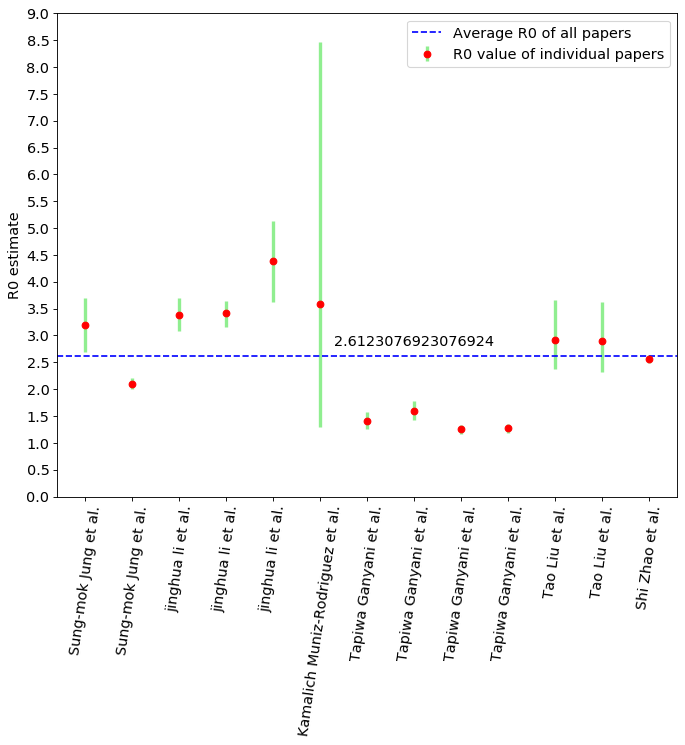

In [7]:
upperLimit=[]
lowerLimit=[]
average=[]
authors=[]

for j in relatedPapers:
    contributions = j['contributions']
    for k in contributions:
        properties=k['contribution_details']
        for p in properties:
            #finding property 'Basic reproduction number'
            if p['property']['label']=='Basic reproduction number':
                
                # if 95% CI is available
                if len(p['contribution_details'])>1 and p['contribution_details'][1]['contribution_details']:
                    
                    #retrieving average R0
                    average.append(float(p['contribution_details'][0]['label']))
                    
                    #getting upper limit
                    upperLimit.append(float(p['contribution_details'][1]['contribution_details'][0]['label']))
                    
                    #getting lower limit
                    lowerLimit.append(float(p['contribution_details'][1]['contribution_details'][1]['label']))
                    
                    authors.append(j['authors'][len(j['authors'])-1]['label']+' et al.')

AggAverage = mean(average)
print('average R0: '+str(AggAverage))

figure(figsize=(10, 8), dpi=80)

ytop = np.array(upperLimit)-np.array(average)
ybot = np.array(average)-np.array(lowerLimit)

x=range(len(authors))
plt.errorbar(x, average, yerr=(ybot,ytop), fmt='o', color='red', ecolor='lightgreen', elinewidth=3, capsize=0)

plt.yticks(np.arange(0, max(upperLimit)+1, 0.5))
plt.axhline(y=AggAverage, color='b', linestyle='--')
plt.text(7,AggAverage+0.2,AggAverage,horizontalalignment='center')

x_pos = np.arange(len(authors))
plt.xticks(x_pos, authors, rotation='82')

plt.legend(["Average R0 of all papers", "R0 value of individual papers"])
    
plt.ylabel('R0 estimate')
plt.rcParams.update({'font.size': 13})
plt.show()

